# Import Libraries

In [233]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from itertools import product
import xgboost as xgb
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

In [234]:
df_100 = pd.read_csv('flights_sample_10k.csv')
df_100.head()

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
0,2022-07-19,SkyWest Airlines Inc.,SkyWest Airlines Inc.: OO,OO,20304,3371,SAN,"San Diego, CA",SFO,"San Francisco, CA",...,0.0,89.0,87.0,63.0,447.0,NaN,NaN,NaN,NaN,NaN
1,2022-09-13,Republic Airline,Republic Airline: YX,YX,20452,3552,CMH,"Columbus, OH",ORD,"Chicago, IL",...,0.0,88.0,78.0,51.0,296.0,NaN,NaN,NaN,NaN,NaN
2,2022-07-09,SkyWest Airlines Inc.,SkyWest Airlines Inc.: OO,OO,20304,4660,CVG,"Cincinnati, OH",ORD,"Chicago, IL",...,0.0,97.0,79.0,53.0,264.0,NaN,NaN,NaN,NaN,NaN
3,2021-03-19,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,325,DEN,"Denver, CO",MCI,"Kansas City, MO",...,0.0,96.0,92.0,72.0,533.0,NaN,NaN,NaN,NaN,NaN
4,2020-01-03,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1561,IAH,"Houston, TX",SFO,"San Francisco, CA",...,0.0,267.0,253.0,223.0,1635.0,NaN,NaN,NaN,NaN,NaN


In [235]:
df_100[df_100['CANCELLED'] == 1] #flights that got cancelled

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
30,2019-06-09,Envoy Air,Envoy Air: MQ,MQ,20398,4157,DFW,"Dallas/Fort Worth, TX",ICT,"Wichita, KS",...,0.0,81.0,NaN,NaN,328.0,NaN,NaN,NaN,NaN,NaN
31,2020-04-03,Envoy Air,Envoy Air: MQ,MQ,20398,4241,SHV,"Shreveport, LA",DFW,"Dallas/Fort Worth, TX",...,0.0,73.0,NaN,NaN,190.0,NaN,NaN,NaN,NaN,NaN
34,2022-12-28,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,1134,IND,"Indianapolis, IN",MCO,"Orlando, FL",...,0.0,140.0,NaN,NaN,829.0,NaN,NaN,NaN,NaN,NaN
65,2020-04-09,Allegiant Air,Allegiant Air: G4,G4,20368,2114,SFB,"Sanford, FL",RFD,"Rockford, IL",...,0.0,162.0,NaN,NaN,1025.0,NaN,NaN,NaN,NaN,NaN
69,2019-09-03,SkyWest Airlines Inc.,SkyWest Airlines Inc.: OO,OO,20304,3272,ORD,"Chicago, IL",OKC,"Oklahoma City, OK",...,0.0,132.0,NaN,NaN,693.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9722,2022-12-26,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,3303,HRL,"Harlingen/San Benito, TX",AUS,"Austin, TX",...,0.0,65.0,NaN,NaN,273.0,NaN,NaN,NaN,NaN,NaN
9732,2020-04-10,Envoy Air,Envoy Air: MQ,MQ,20398,3361,ORD,"Chicago, IL",BNA,"Nashville, TN",...,0.0,94.0,NaN,NaN,409.0,NaN,NaN,NaN,NaN,NaN
9877,2020-03-28,PSA Airlines Inc.,PSA Airlines Inc.: OH,OH,20397,5385,CLT,"Charlotte, NC",RIC,"Richmond, VA",...,0.0,73.0,NaN,NaN,257.0,NaN,NaN,NaN,NaN,NaN
9908,2022-06-02,American Airlines Inc.,American Airlines Inc.: AA,AA,19805,2414,DFW,"Dallas/Fort Worth, TX",IAD,"Washington, DC",...,0.0,174.0,NaN,NaN,1172.0,NaN,NaN,NaN,NaN,NaN


In [236]:
delay_cols = ['DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER',
               'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY',
               'DELAY_DUE_LATE_AIRCRAFT']

df_100[delay_cols] = df_100[delay_cols].fillna(0)

In [237]:
df_100.isnull().sum()  #missing values

,0
FL_DATE,0
AIRLINE,0
AIRLINE_DOT,0
AIRLINE_CODE,0
DOT_CODE,0
FL_NUMBER,0
ORIGIN,0
ORIGIN_CITY,0
DEST,0
DEST_CITY,0


# Using an AutoEDA

In [238]:
# pip install ydata-profiling -q

In [239]:
# import pandas as pd
# from ydata_profiling import ProfileReport

# profile = ProfileReport(df_10, title="Pandas Profiling Report")
# profile.to_file("output_report.json")

# Data Preprocessing

After I went through the dataset, there are some columns that I think are not useful since our target is the Arrival delay time.

## Outlier detection and deletion

Some features have extreme outliers, here we decide to delete those outliers, especially in DEP_DELAY, TAXI_OUT, TAXI_IN,ARR_DELAY

In [240]:
def remove_outliers_iqr(dataframe):
    df = dataframe.copy()

    numeric_cols = df.select_dtypes(include='number').columns

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filter rows where values are within bounds
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    # Print how many rows were removed
    rows_removed = len(dataframe) - len(df)
    print(f"Removed {rows_removed} rows containing outliers")

    return df

df = remove_outliers_iqr(df_100)

Removed 3260 rows containing outliers


## Convert Time

Cyclical encoding is a technique used in machine learning to represent cyclical features, such as time, in a way that preserves their inherent periodic nature. This is particularly important for features like hours of the day, days of the week, or months of the year, where the end of the cycle wraps around to the beginning (e.g., after 23:00 comes 00:00).

**Why Use Cyclical Encoding?**

1. Preserves Relationships: In a standard numerical representation, the distance between values at the ends of the cycle (e.g., 23:00 and 00:00) would be large (23 units apart), which does not reflect their actual closeness in time. Cyclical encoding helps to maintain this relationship.

2. Improves Model Performance: Many machine learning algorithms, especially linear models, can misinterpret the cyclical nature of time if it is not encoded properly. Cyclical encoding can lead to better model performance by providing a more accurate representation of the data.

![image.png](attachment:ac8e5833-128b-4f9a-b289-6499fbc78f2d.png)

In [241]:
import pandas as pd
import numpy as np

def cyclical_encoding(t):
    """Return sine and cosine transformations for time in HHMM format."""
    if pd.isnull(t):
        return np.nan, np.nan, np.nan, np.nan  # Return NaN for sine and cosine if input is NaN
    else:
        t = int(t)
        hour = t // 100
        minute = t % 100

        # Normalize hour and minute
        hour_norm = hour / 24
        minute_norm = minute / 60

        # Calculate sine and cosine for cyclical encoding
        hour_sin = np.sin(2 * np.pi * hour_norm)
        hour_cos = np.cos(2 * np.pi * hour_norm)
        minute_sin = np.sin(2 * np.pi * minute_norm)
        minute_cos = np.cos(2 * np.pi * minute_norm)

        return hour_sin, hour_cos, minute_sin, minute_cos

# List of original time columns to convert
time_columns = ['CRS_DEP_TIME', 'CRS_ARR_TIME', 'WHEELS_OFF', 'WHEELS_ON', 'DEP_TIME', 'ARR_TIME']

# Process each time column
for col in time_columns:
    if col in df.columns:
        # Apply cyclical encoding
        df[[f'{col}_HOUR_SIN', f'{col}_HOUR_COS', f'{col}_MINUTE_SIN', f'{col}_MINUTE_COS']] = df[col].apply(
            lambda x: pd.Series(cyclical_encoding(x))
        )
    else:
        print(f"Column {col} not found in DataFrame")

In [242]:
df.head()

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,WHEELS_ON_MINUTE_SIN,WHEELS_ON_MINUTE_COS,DEP_TIME_HOUR_SIN,DEP_TIME_HOUR_COS,DEP_TIME_MINUTE_SIN,DEP_TIME_MINUTE_COS,ARR_TIME_HOUR_SIN,ARR_TIME_HOUR_COS,ARR_TIME_MINUTE_SIN,ARR_TIME_MINUTE_COS
0,2022-07-19,SkyWest Airlines Inc.,SkyWest Airlines Inc.: OO,OO,20304,3371,SAN,"San Diego, CA",SFO,"San Francisco, CA",...,0.994522,-0.104528,-0.965926,-2.588190e-01,0.000000,1.000000e+00,-1.000000e+00,-1.836970e-16,0.309017,-0.951057
1,2022-09-13,Republic Airline,Republic Airline: YX,YX,20452,3552,CMH,"Columbus, OH",ORD,"Chicago, IL",...,0.500000,-0.866025,0.258819,-9.659258e-01,0.951057,-3.090170e-01,2.588190e-01,-9.659258e-01,-0.587785,-0.809017
2,2022-07-09,SkyWest Airlines Inc.,SkyWest Airlines Inc.: OO,OO,20304,4660,CVG,"Cincinnati, OH",ORD,"Chicago, IL",...,0.587785,-0.809017,0.258819,-9.659258e-01,0.978148,2.079117e-01,2.588190e-01,-9.659258e-01,-0.207912,-0.978148
3,2021-03-19,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,325,DEN,"Denver, CO",MCI,"Kansas City, MO",...,-0.951057,-0.309017,-1.000000,-1.836970e-16,1.000000,6.123234e-17,-8.660254e-01,5.000000e-01,-0.978148,0.207912
4,2020-01-03,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1561,IAH,"Houston, TX",SFO,"San Francisco, CA",...,0.500000,0.866025,0.500000,-8.660254e-01,0.104528,9.945219e-01,1.224647e-16,-1.000000e+00,0.994522,0.104528


In [243]:
df['ARR_DELAY'].tail()

,ARR_DELAY
9990,-7.0
9992,-17.0
9994,8.0
9995,-27.0
9998,-20.0


In [244]:
df.columns

Index(['FL_DATE', 'AIRLINE', 'AIRLINE_DOT', 'AIRLINE_CODE', 'DOT_CODE',
       'FL_NUMBER', 'ORIGIN', 'ORIGIN_CITY', 'DEST', 'DEST_CITY',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'DELAY_DUE_CARRIER',
       'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY',
       'DELAY_DUE_LATE_AIRCRAFT', 'CRS_DEP_TIME_HOUR_SIN',
       'CRS_DEP_TIME_HOUR_COS', 'CRS_DEP_TIME_MINUTE_SIN',
       'CRS_DEP_TIME_MINUTE_COS', 'CRS_ARR_TIME_HOUR_SIN',
       'CRS_ARR_TIME_HOUR_COS', 'CRS_ARR_TIME_MINUTE_SIN',
       'CRS_ARR_TIME_MINUTE_COS', 'WHEELS_OFF_HOUR_SIN', 'WHEELS_OFF_HOUR_COS',
       'WHEELS_OFF_MINUTE_SIN', 'WHEELS_OFF_MINUTE_COS', 'WHEELS_ON_HOUR_SIN',
       'WHEELS_ON_HOUR_COS', 'WHEELS_ON_MINUTE_SIN', 'WHEELS_ON_MINUTE_COS',
       'DEP_TIME_HOUR_SIN', 'DEP_TIM

## Scaling

Scaling will be executed if needed, since logically speaking, scaling wouldn't do any good, because our target, arrival delay will be affected.

In [245]:
# df['TAXI_IN'] = df['CRS_DEP_TIME'].apply(convert_time)
# df['TAXI_OUT'] = df['CRS_DEP_TIME'].apply(convert_time)

## Making 2 new columns, which are the States of destination and departure

In [246]:
import pandas as pd

def split_and_overwrite_city_state(df, column_names):
    """Splits columns like 'DEST_CITY' into 'dest_city' and 'dest_state' (no redundant naming)."""
    df = df.copy()

    for column_name in column_names:
        # Extract base name ('DEST' → 'dest')
        base_name = column_name.split('_')[0].lower()

        # Split city and state (e.g., "New York, NY" → ["New York", "NY"])
        split_result = df[column_name].str.split(r'\s*,\s*', n=1, expand=True)

        # Replace original column with clean city name
        df[column_name] = split_result[0].str.strip()

        # Add new state column
        df[f"{base_name}_state"] = split_result[1].str.strip()

    return df

# Example usage:
df = split_and_overwrite_city_state(df, ['DEST_CITY', 'ORIGIN_CITY'])
df.head()

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,DEP_TIME_HOUR_SIN,DEP_TIME_HOUR_COS,DEP_TIME_MINUTE_SIN,DEP_TIME_MINUTE_COS,ARR_TIME_HOUR_SIN,ARR_TIME_HOUR_COS,ARR_TIME_MINUTE_SIN,ARR_TIME_MINUTE_COS,dest_state,origin_state
0,2022-07-19,SkyWest Airlines Inc.,SkyWest Airlines Inc.: OO,OO,20304,3371,SAN,San Diego,SFO,San Francisco,...,-0.965926,-2.588190e-01,0.000000,1.000000e+00,-1.000000e+00,-1.836970e-16,0.309017,-0.951057,CA,CA
1,2022-09-13,Republic Airline,Republic Airline: YX,YX,20452,3552,CMH,Columbus,ORD,Chicago,...,0.258819,-9.659258e-01,0.951057,-3.090170e-01,2.588190e-01,-9.659258e-01,-0.587785,-0.809017,IL,OH
2,2022-07-09,SkyWest Airlines Inc.,SkyWest Airlines Inc.: OO,OO,20304,4660,CVG,Cincinnati,ORD,Chicago,...,0.258819,-9.659258e-01,0.978148,2.079117e-01,2.588190e-01,-9.659258e-01,-0.207912,-0.978148,IL,OH
3,2021-03-19,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,325,DEN,Denver,MCI,Kansas City,...,-1.000000,-1.836970e-16,1.000000,6.123234e-17,-8.660254e-01,5.000000e-01,-0.978148,0.207912,MO,CO
4,2020-01-03,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1561,IAH,Houston,SFO,San Francisco,...,0.500000,-8.660254e-01,0.104528,9.945219e-01,1.224647e-16,-1.000000e+00,0.994522,0.104528,CA,TX


In [247]:
df.columns

Index(['FL_DATE', 'AIRLINE', 'AIRLINE_DOT', 'AIRLINE_CODE', 'DOT_CODE',
       'FL_NUMBER', 'ORIGIN', 'ORIGIN_CITY', 'DEST', 'DEST_CITY',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'DELAY_DUE_CARRIER',
       'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY',
       'DELAY_DUE_LATE_AIRCRAFT', 'CRS_DEP_TIME_HOUR_SIN',
       'CRS_DEP_TIME_HOUR_COS', 'CRS_DEP_TIME_MINUTE_SIN',
       'CRS_DEP_TIME_MINUTE_COS', 'CRS_ARR_TIME_HOUR_SIN',
       'CRS_ARR_TIME_HOUR_COS', 'CRS_ARR_TIME_MINUTE_SIN',
       'CRS_ARR_TIME_MINUTE_COS', 'WHEELS_OFF_HOUR_SIN', 'WHEELS_OFF_HOUR_COS',
       'WHEELS_OFF_MINUTE_SIN', 'WHEELS_OFF_MINUTE_COS', 'WHEELS_ON_HOUR_SIN',
       'WHEELS_ON_HOUR_COS', 'WHEELS_ON_MINUTE_SIN', 'WHEELS_ON_MINUTE_COS',
       'DEP_TIME_HOUR_SIN', 'DEP_TIM

## Making Weekdays, Weekends, and Days name from dates

In [248]:
   import pandas as pd

   def add_weekday_weekend_columns(df, date_columns):
       """Adds weekday name, and weekend boolean for each date column.
       Args:
           df (pd.DataFrame): Input DataFrame.
           date_columns (list): List of column names containing dates.
       Returns:
           pd.DataFrame: DataFrame with added day-related columns.
       """
       df = df.copy()

       for col in date_columns:
           # Ensure column is in datetime format
           if not pd.api.types.is_datetime64_any_dtype(df[col]):
               df[col] = pd.to_datetime(df[col], errors='coerce')

           # Add Day Name (e.g., 'Monday')
           df[f'{col}_day_name'] = df[col].dt.day_name()

           # Add Weekend Boolean (True if Saturday/Sunday)
           df[f'{col}_is_weekend'] = df[col].dt.dayofweek.isin([5, 6])  # 5=Sat, 6=Sun

       return df

   # Example Usage
   df = add_weekday_weekend_columns(df, ['FL_DATE'])


In [249]:
df.head()

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,DEP_TIME_MINUTE_SIN,DEP_TIME_MINUTE_COS,ARR_TIME_HOUR_SIN,ARR_TIME_HOUR_COS,ARR_TIME_MINUTE_SIN,ARR_TIME_MINUTE_COS,dest_state,origin_state,FL_DATE_day_name,FL_DATE_is_weekend
0,2022-07-19,SkyWest Airlines Inc.,SkyWest Airlines Inc.: OO,OO,20304,3371,SAN,San Diego,SFO,San Francisco,...,0.000000,1.000000e+00,-1.000000e+00,-1.836970e-16,0.309017,-0.951057,CA,CA,Tuesday,False
1,2022-09-13,Republic Airline,Republic Airline: YX,YX,20452,3552,CMH,Columbus,ORD,Chicago,...,0.951057,-3.090170e-01,2.588190e-01,-9.659258e-01,-0.587785,-0.809017,IL,OH,Tuesday,False
2,2022-07-09,SkyWest Airlines Inc.,SkyWest Airlines Inc.: OO,OO,20304,4660,CVG,Cincinnati,ORD,Chicago,...,0.978148,2.079117e-01,2.588190e-01,-9.659258e-01,-0.207912,-0.978148,IL,OH,Saturday,True
3,2021-03-19,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,325,DEN,Denver,MCI,Kansas City,...,1.000000,6.123234e-17,-8.660254e-01,5.000000e-01,-0.978148,0.207912,MO,CO,Friday,False
4,2020-01-03,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1561,IAH,Houston,SFO,San Francisco,...,0.104528,9.945219e-01,1.224647e-16,-1.000000e+00,0.994522,0.104528,CA,TX,Friday,False


In [250]:
df.columns

Index(['FL_DATE', 'AIRLINE', 'AIRLINE_DOT', 'AIRLINE_CODE', 'DOT_CODE',
       'FL_NUMBER', 'ORIGIN', 'ORIGIN_CITY', 'DEST', 'DEST_CITY',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'DELAY_DUE_CARRIER',
       'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY',
       'DELAY_DUE_LATE_AIRCRAFT', 'CRS_DEP_TIME_HOUR_SIN',
       'CRS_DEP_TIME_HOUR_COS', 'CRS_DEP_TIME_MINUTE_SIN',
       'CRS_DEP_TIME_MINUTE_COS', 'CRS_ARR_TIME_HOUR_SIN',
       'CRS_ARR_TIME_HOUR_COS', 'CRS_ARR_TIME_MINUTE_SIN',
       'CRS_ARR_TIME_MINUTE_COS', 'WHEELS_OFF_HOUR_SIN', 'WHEELS_OFF_HOUR_COS',
       'WHEELS_OFF_MINUTE_SIN', 'WHEELS_OFF_MINUTE_COS', 'WHEELS_ON_HOUR_SIN',
       'WHEELS_ON_HOUR_COS', 'WHEELS_ON_MINUTE_SIN', 'WHEELS_ON_MINUTE_COS',
       'DEP_TIME_HOUR_SIN', 'DEP_TIM

## Exclude some Columns

Some Columns need to be exluded for some reasons, for example not useful to the target variable or redundant (as some variables are represented only in 1 variables, e.g. airline code)

In [251]:
columns_to_exclude = [
    'AIRLINE_DOT', 'AIRLINE_CODE', 'DOT_CODE', 'CANCELLED',
    'CANCELLATION_CODE', 'DIVERTED', 'DELAY_DUE_CARRIER',
    'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY',
    'DELAY_DUE_LATE_AIRCRAFT'
]
# Drop the specified columns
df = df.drop(columns=columns_to_exclude)

In [252]:
df.head()

,FL_DATE,AIRLINE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,...,DEP_TIME_MINUTE_SIN,DEP_TIME_MINUTE_COS,ARR_TIME_HOUR_SIN,ARR_TIME_HOUR_COS,ARR_TIME_MINUTE_SIN,ARR_TIME_MINUTE_COS,dest_state,origin_state,FL_DATE_day_name,FL_DATE_is_weekend
0,2022-07-19,SkyWest Airlines Inc.,3371,SAN,San Diego,SFO,San Francisco,1705,1700.0,-5.0,...,0.000000,1.000000e+00,-1.000000e+00,-1.836970e-16,0.309017,-0.951057,CA,CA,Tuesday,False
1,2022-09-13,Republic Airline,3552,CMH,Columbus,ORD,Chicago,1119,1118.0,-1.0,...,0.951057,-3.090170e-01,2.588190e-01,-9.659258e-01,-0.587785,-0.809017,IL,OH,Tuesday,False
2,2022-07-09,SkyWest Airlines Inc.,4660,CVG,Cincinnati,ORD,Chicago,1118,1113.0,-5.0,...,0.978148,2.079117e-01,2.588190e-01,-9.659258e-01,-0.207912,-0.978148,IL,OH,Saturday,True
3,2021-03-19,United Air Lines Inc.,325,DEN,Denver,MCI,Kansas City,1815,1815.0,0.0,...,1.000000,6.123234e-17,-8.660254e-01,5.000000e-01,-0.978148,0.207912,MO,CO,Friday,False
4,2020-01-03,United Air Lines Inc.,1561,IAH,Houston,SFO,San Francisco,1000,1001.0,1.0,...,0.104528,9.945219e-01,1.224647e-16,-1.000000e+00,0.994522,0.104528,CA,TX,Friday,False


In [253]:
df.columns

Index(['FL_DATE', 'AIRLINE', 'FL_NUMBER', 'ORIGIN', 'ORIGIN_CITY', 'DEST',
       'DEST_CITY', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME',
       'ARR_DELAY', 'CRS_ELAPSED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'CRS_DEP_TIME_HOUR_SIN', 'CRS_DEP_TIME_HOUR_COS',
       'CRS_DEP_TIME_MINUTE_SIN', 'CRS_DEP_TIME_MINUTE_COS',
       'CRS_ARR_TIME_HOUR_SIN', 'CRS_ARR_TIME_HOUR_COS',
       'CRS_ARR_TIME_MINUTE_SIN', 'CRS_ARR_TIME_MINUTE_COS',
       'WHEELS_OFF_HOUR_SIN', 'WHEELS_OFF_HOUR_COS', 'WHEELS_OFF_MINUTE_SIN',
       'WHEELS_OFF_MINUTE_COS', 'WHEELS_ON_HOUR_SIN', 'WHEELS_ON_HOUR_COS',
       'WHEELS_ON_MINUTE_SIN', 'WHEELS_ON_MINUTE_COS', 'DEP_TIME_HOUR_SIN',
       'DEP_TIME_HOUR_COS', 'DEP_TIME_MINUTE_SIN', 'DEP_TIME_MINUTE_COS',
       'ARR_TIME_HOUR_SIN', 'ARR_TIME_HOUR_COS', 'ARR_TIME_MINUTE_SIN',
       'ARR_TIME_MINUTE_COS', 'dest_state', 'origin_state', 'FL_DATE_day_name',
       

Here we have our focus of project, classification of whether a flight will be late or not, we classified a flight to be late if the flight is above 15 minutes

In [254]:
df['Late'] = (df['ARR_DELAY'] >= -15).astype(int)

In [255]:
# # Example: convert datetime to numeric features
# df['FL_YEAR'] = df['FL_DATE'].dt.year
# df['FL_MONTH'] = df['FL_DATE'].dt.month
# df['FL_DAY'] = df['FL_DATE'].dt.day
# df['FL_DOW'] = df['FL_DATE'].dt.dayofweek  # Day of week

# # Drop original datetime column
# df = df.drop(columns=['FL_DATE'])

from sklearn.preprocessing import LabelEncoder

for col in ['DEST', 'DEST_CITY']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [256]:
df['Late']

,Late
0,1
1,1
2,0
3,1
4,1
...,...
9990,1
9992,0
9994,1
9995,0


# Feature Extraction

In order to create a more powerful model, we are creating new features that can be extracted

In [257]:
df['CRS_DEP_TIME'] = df['CRS_DEP_TIME'].astype(int)
df['DEP_TIME'] = df['DEP_TIME'].astype(float)
df['CRS_ARR_TIME'] = df['CRS_ARR_TIME'].astype(int)
df['ARR_TIME'] = df['ARR_TIME'].astype(float)

In [258]:
# Helper function to convert HHMM to minutes
def hhmm_to_minutes(hhmm):
    hours = hhmm // 100
    minutes = hhmm % 100
    return hours * 60 + minutes

**Refined Airport Congestion Index (RACI)**
   
**Purpose:** Measure departure congestion at the ORIGIN airport (e.g., SFO, ORD) to predict delays and help airports manage resources like gates and runways.

**Definition:** Count flights departing from the same ORIGIN airport on the same FL_DATE within a ±1-hour window of CRS_DEP_TIME. This captures peak traffic periods more efficiently than the original ACI.

**Why It’s Useful:**
* Airports: Identifies high-traffic periods for scheduling ground crews or runway slots.
* Prediction: Higher congestion increases DEP_DELAY, which correlates with Late (arrival delay > 15 minutes).

In [259]:
# 1. Refined Airport Congestion Index (RACI)
def calculate_raci(df):
    df['DEP_TIME_MINUTES'] = df['CRS_DEP_TIME'].apply(hhmm_to_minutes)
    df['RACI'] = 0
    # Group by FL_DATE and ORIGIN for efficiency
    grouped = df.groupby(['FL_DATE', 'ORIGIN'])
    for (date, origin), group in grouped:
        for idx in group.index:
            time_window = 60  # ±1 hour
            time_range = (group['DEP_TIME_MINUTES'] >= group.loc[idx, 'DEP_TIME_MINUTES'] - time_window) & \
                         (group['DEP_TIME_MINUTES'] <= group.loc[idx, 'DEP_TIME_MINUTES'] + time_window)
            df.loc[idx, 'RACI'] = time_range.sum()
    return df.drop(columns=['DEP_TIME_MINUTES'])

**Airport Delay Propensity (ADP)**
   
**Purpose:** Capture the historical delay likelihood at the ORIGIN airport, replacing HIS to focus on delay risk rather than hub status.

**Definition:** Compute the proportion of flights from each ORIGIN airport with Late == 1 (or ARR_DELAY > 15) in the dataset. Assign this value to each flight based on its ORIGIN.

**Why It’s Useful:**

* Airports: Highlights airports prone to delays (e.g., ORD, EWR), aiding resource planning.
* Prediction: Airports with high delay rates are more likely to produce late flights.

In [260]:
# 2. Airport Delay Propensity (ADP)
def calculate_adp(df):
    # Calculate proportion of Late == 1 per ORIGIN
    adp_scores = df.groupby('ORIGIN')['Late'].mean()
    df['ADP'] = df['ORIGIN'].map(adp_scores)
    # Fill missing values with overall mean
    df['ADP'] = df['ADP'].fillna(df['Late'].mean())
    return df

**Total Taxi Time (TTT)**

**Purpose:** Quantify ground operation time to reflect airport efficiency, replacing TTR to avoid using DISTANCE.

**Definition:**
$$\text{TTT} = \text{TAXI\_OUT} + \text{TAXI\_IN}$$
This measures the total time spent taxiing at both origin and destination airports.

**Why It’s Useful:**

* Airports: Long taxi times indicate congestion or inefficiencies, helping optimize ground operations.
* Prediction: Longer taxi times correlate with delays, as they may reflect airport bottlenecks.

In [261]:
# 3. Total Taxi Time (TTT)
def calculate_ttt(df):
    df['TTT'] = df['TAXI_OUT'] + df['TAXI_IN']
    # Handle any extreme values
    df['TTT'] = df['TTT'].clip(upper=120)  # Cap at 2 hours for robustness
    return df

**Historical Delay Severity (HDS)**

**Purpose:** Capture the average severity of delays at the ORIGIN airport, addressing DCW’s sparsity issue.

**Definition:** Compute the average ARR_DELAY for flights with ARR_DELAY > 0 per ORIGIN airport, assigning this value to each flight. For airports with no delays, use the dataset’s overall average delay.

**Why It’s Useful:**

* Airports: Identifies airports with severe delays, aiding in contingency planning.
* Prediction: Airports with higher average delays are more likely to produce Late flights.

In [262]:
# 4. Historical Delay Severity (HDS)
def calculate_hds(df):
    # Calculate average ARR_DELAY for delayed flights per ORIGIN
    delayed_flights = df[df['ARR_DELAY'] > 0]
    hds_scores = delayed_flights.groupby('ORIGIN')['ARR_DELAY'].mean()
    df['HDS'] = df['ORIGIN'].map(hds_scores)
    # Fill missing values with overall mean delay
    overall_mean_delay = delayed_flights['ARR_DELAY'].mean()
    df['HDS'] = df['HDS'].fillna(overall_mean_delay)
    return df

**Refined Time-of-Day Risk (TODR)**

**Purpose:** Enhance the original TODR to capture delay risk by time of day, optimized for airport scheduling and prediction.

**Definition:** Bin CRS_DEP_TIME into four time slots (e.g., 00:00–05:59, 06:00–11:59, 12:00–17:59, 18:00–23:59) and compute the proportion of Late == 1 flights in each bin. Assign the delay probability to each flight based on its time slot.

**Why It’s Useful:**

* Airports: Highlights peak delay times (e.g., evening) for staffing or gate management.
* Prediction: Time slots with higher delay rates improve Late classification.

In [263]:
# 5. Refined Time-of-Day Risk (TODR)
def calculate_todr(df):
    df['DEP_TIME_MINUTES'] = df['CRS_DEP_TIME'].apply(hhmm_to_minutes)
    # Define time bins: 00:00-05:59, 06:00-11:59, 12:00-17:59, 18:00-23:59
    bins = [0, 6*60, 12*60, 18*60, 24*60]
    labels = ['Early Morning', 'Morning', 'Afternoon', 'Evening']
    df['Time_Bin'] = pd.cut(df['DEP_TIME_MINUTES'], bins=bins, labels=labels, include_lowest=True)
    # Calculate delay probability per bin
    delay_rates = df.groupby('Time_Bin')['Late'].mean()
    # Map delay rates and convert to float to avoid categorical issues
    df['TODR'] = df['Time_Bin'].map(delay_rates).astype(float)
    # Fill missing values with overall delay rate
    df['TODR'] = df['TODR'].fillna(df['Late'].mean())
    return df.drop(columns=['DEP_TIME_MINUTES', 'Time_Bin'])

In [264]:
df = calculate_raci(df)
df = calculate_adp(df)
df = calculate_ttt(df)
df = calculate_hds(df)
df = calculate_todr(df)

/tmp/ipython-input-263-1876473327.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  delay_rates = df.groupby('Time_Bin')['Late'].mean()


# Encoding for Categorical Data

1. One-Hot Encoding
* Use Case: Best for nominal data (categories without an inherent order).
* Description: Creates a new binary column for each category, indicating the presence (1) or absence (0) of that category.

2. Label Encoding
* Use Case: Suitable for ordinal data (categories with a defined order).
* Description: Assigns a unique integer to each category, which can imply an order.

3. Ordinal Encoding
* Use Case: Specifically for ordinal data where the order matters.
* Description: Converts categories into integers while preserving the order.

4. Binary Encoding
* Use Case: Effective for high cardinality features (many unique categories).
* Description: Converts categories into binary digits, reducing dimensionality compared to one-hot encoding.
  
5. Target Encoding
* Use Case: Useful when there is a relationship between the categorical feature and the target variable.
* Description: Replaces categories with the mean of the target variable for that category.

In [265]:
# !pip install -q category_encoders

In [266]:
import joblib
import category_encoders as ce
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# 1. Ordinal Encoding
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ordinal_enc = OrdinalEncoder(categories=[day_order])
df['FL_DATE_day_name_encoded'] = ordinal_enc.fit_transform(df[['FL_DATE_day_name']])
joblib.dump(ordinal_enc, 'ordinal_enc.pkl')

# 2. One-Hot Encoding
onehot_enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
airline_encoded = onehot_enc.fit_transform(df[['AIRLINE']])
airline_columns = [f'AIRLINE_{cat}' for cat in onehot_enc.categories_[0]]
df[airline_columns] = airline_encoded
joblib.dump(onehot_enc, 'onehot_enc.pkl')

# 3. Binary Encoding
binary_cols = ['FL_NUMBER', 'ORIGIN', 'ORIGIN_CITY', 'dest_state', 'origin_state']
binary_enc = ce.BinaryEncoder(cols=binary_cols)
binary_enc.fit(df[binary_cols])  # ✅ Fit only on relevant cols
joblib.dump(binary_enc, 'binary_enc.pkl')

# Drop original columns
df = df.drop(columns=['FL_DATE_day_name', 'AIRLINE'])

In [ ]:
df.drop(columns=['ARR_DELAY'], inplace=True)

In [ ]:
# Example: convert datetime to numeric features
df['FL_YEAR'] = df['FL_DATE'].dt.year
df['FL_MONTH'] = df['FL_DATE'].dt.month
df['FL_DAY'] = df['FL_DATE'].dt.day
df['FL_DOW'] = df['FL_DATE'].dt.dayofweek  # Day of week

# Drop original datetime column
df = df.drop(columns=['FL_DATE'])

In [83]:
df.to_csv('encoded_flight_data.csv', index=False)

# Hyperparameter Optimization (HPO)

In [84]:
X = df.drop(columns=['Late'])
y = df['Late']

In [85]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [15, 31, 63],
    'max_depth': [5, 7, -1],  # -1 means no limit
    'min_data_in_leaf': [20, 50],
    'feature_fraction': [0.8, 1.0]
}

# Generate all combinations of hyperparameters
param_combinations = list(product(*param_grid.values()))
best_auc = 0
best_params = None
best_model = None

In [86]:
param_combinations = list(product(*param_grid.values()))
best_auc = 0
best_params = None
best_model = None

In [87]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [88]:
# Dynamically build categorical columns list
categorical_columns = ['Year', 'Month', 'Day', 'FL_DATE_day_name_encoded'] + \
                     [col for col in X.columns if col.startswith(('AIRLINE_', 'FL_NUMBER_', 'ORIGIN_', 'ORIGIN_CITY_', 'dest_state_', 'origin_state_'))]
# Filter to ensure only existing columns are included
categorical_columns = [col for col in categorical_columns if col in X.columns]

In [89]:
# Prepare features and target
X = df.drop(columns=['Late'])
y = df['Late']

# Debug: Print columns to verify
print("Columns in X:", X.columns.tolist())

# Ensure all columns are numeric (encoding ensures this)
for col in X.columns:
    X[col] = X[col].astype(float)

# Define hyperparameter grid for XGBoost
param_grid = {
    'eta': [0.01, 0.05, 0.1],  # Learning rate
    'max_depth': [5, 7, 10],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Generate all combinations of hyperparameters
param_combinations = list(product(*param_grid.values()))
best_auc = 0
best_params = None
best_model = None
best_metrics = None

# Stratified K-Fold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Hyperparameter optimization
for params in param_combinations:
    eta, max_depth, min_child_weight, subsample, colsample_bytree = params
    current_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'eta': eta,
        'max_depth': max_depth,
        'min_child_weight': min_child_weight,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'seed': 42,
        'verbosity': 0
    }

    auc_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    models = []

    print(f"Testing params: {current_params}")

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Create XGBoost DMatrix
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)

        # Train model
        model = xgb.train(
            current_params,
            dtrain,
            num_boost_round=1000,
            evals=[(dtrain, 'train'), (dval, 'val')],
            early_stopping_rounds=50,
            verbose_eval=False
        )

        # Predict and evaluate
        y_pred = model.predict(dval)
        auc = roc_auc_score(y_val, y_pred)
        y_pred_binary = (y_pred > 0.5).astype(int)
        precision = precision_score(y_val, y_pred_binary, zero_division=0)
        recall = recall_score(y_val, y_pred_binary, zero_division=0)
        f1 = f1_score(y_val, y_pred_binary, zero_division=0)

        auc_scores.append(auc)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        models.append(model)

    mean_auc = np.mean(auc_scores)
    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)
    mean_f1 = np.mean(f1_scores)

    print(f"Mean AUC: {mean_auc:.4f} ± {np.std(auc_scores):.4f}")
    print(f"Mean Precision: {mean_precision:.4f} ± {np.std(precision_scores):.4f}")
    print(f"Mean Recall: {mean_recall:.4f} ± {np.std(recall_scores):.4f}")
    print(f"Mean F1: {mean_f1:.4f} ± {np.std(f1_scores):.4f}\n")

    if mean_auc > best_auc:
        best_auc = mean_auc
        best_params = current_params
        best_model = models[np.argmax(auc_scores)]
        best_metrics = {
            'auc': mean_auc,
            'precision': mean_precision,
            'recall': mean_recall,
            'f1': mean_f1
        }

# Final result
print(f"\nBest Parameters: {best_params}")
print(f"Best Mean AUC: {best_metrics['auc']:.4f}")
print(f"Best Mean Precision: {best_metrics['precision']:.4f}")
print(f"Best Mean Recall: {best_metrics['recall']:.4f}")
print(f"Best Mean F1: {best_metrics['f1']:.4f}")

# Save the best model
best_model.save_model('best_xgb_model.json')

# Save the updated dataset
df.to_csv('flights_with_revised_features.csv', index=False)

Columns in X: ['FL_NUMBER_0', 'FL_NUMBER_1', 'FL_NUMBER_2', 'FL_NUMBER_3', 'FL_NUMBER_4', 'FL_NUMBER_5', 'FL_NUMBER_6', 'FL_NUMBER_7', 'FL_NUMBER_8', 'FL_NUMBER_9', 'FL_NUMBER_10', 'FL_NUMBER_11', 'ORIGIN_0', 'ORIGIN_1', 'ORIGIN_2', 'ORIGIN_3', 'ORIGIN_4', 'ORIGIN_5', 'ORIGIN_6', 'ORIGIN_7', 'ORIGIN_8', 'ORIGIN_CITY_0', 'ORIGIN_CITY_1', 'ORIGIN_CITY_2', 'ORIGIN_CITY_3', 'ORIGIN_CITY_4', 'ORIGIN_CITY_5', 'ORIGIN_CITY_6', 'ORIGIN_CITY_7', 'ORIGIN_CITY_8', 'DEST', 'DEST_CITY', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'CRS_ELAPSED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CRS_DEP_TIME_HOUR_SIN', 'CRS_DEP_TIME_HOUR_COS', 'CRS_DEP_TIME_MINUTE_SIN', 'CRS_DEP_TIME_MINUTE_COS', 'CRS_ARR_TIME_HOUR_SIN', 'CRS_ARR_TIME_HOUR_COS', 'CRS_ARR_TIME_MINUTE_SIN', 'CRS_ARR_TIME_MINUTE_COS', 'WHEELS_OFF_HOUR_SIN', 'WHEELS_OFF_HOUR_COS', 'WHEELS_OFF_MINUTE_SIN', 'WHEELS_OFF_MINUTE_COS', 'WHEELS_ON_HOUR_SIN', 'WHEELS_ON_HOUR_

In [280]:
expected_features = best_model.feature_names

# Testing with Unseen data

In [378]:
df_test = pd.read_csv('flights_sample_100k.csv')
df_test = df_test[:1000]

In [379]:
df_test.shape

(1000, 32)

# Data Preprocessing the Test Data

In [380]:
# df_test = remove_outliers_iqr(df_test)
df_test = split_and_overwrite_city_state(df_test, ['DEST_CITY', 'ORIGIN_CITY'])
df_test = add_weekday_weekend_columns(df_test, ['FL_DATE'])
df_test = df_test.drop(columns=columns_to_exclude)

df_test['CRS_DEP_TIME'] = df_test['CRS_DEP_TIME'].astype(int)
df_test['DEP_TIME'] = df_test['DEP_TIME'].astype(float)
df_test['CRS_ARR_TIME'] = df_test['CRS_ARR_TIME'].astype(int)
df_test['ARR_TIME'] = df_test['ARR_TIME'].astype(float)

df_test['Late'] = (df_test['ARR_DELAY'] >= -15).astype(int)

df_test = calculate_raci(df_test)
df_test = calculate_adp(df_test)
df_test = calculate_ttt(df_test)
df_test = calculate_hds(df_test)
df_test = calculate_todr(df_test)

/tmp/ipython-input-263-1876473327.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  delay_rates = df.groupby('Time_Bin')['Late'].mean()


In [381]:
for col in time_columns:
    if col in df_test.columns:
        # Apply cyclical encoding
        df_test[[f'{col}_HOUR_SIN', f'{col}_HOUR_COS', f'{col}_MINUTE_SIN', f'{col}_MINUTE_COS']] = df[col].apply(
            lambda x: pd.Series(cyclical_encoding(x))
        )
    else:
        print(f"Column {col} not found in DataFrame")

In [382]:
import joblib

# Load encoders
ordinal_enc = joblib.load('ordinal_enc.pkl')
onehot_enc = joblib.load('onehot_enc.pkl')
binary_enc = joblib.load('binary_enc.pkl')

# Apply same transformations
df_test['FL_DATE_day_name_encoded'] = ordinal_enc.transform(df_test[['FL_DATE_day_name']])

airline_encoded = onehot_enc.transform(df_test[['AIRLINE']])
airline_columns = [f'AIRLINE_{cat}' for cat in onehot_enc.categories_[0]]
df_test[airline_columns] = airline_encoded

binary_encoded = binary_enc.transform(df_test[binary_cols])
df_test = df_test.drop(columns=binary_cols)
df_test = pd.concat([df_test, binary_encoded], axis=1)

# Drop original columns
df_test = df_test.drop(columns=['FL_DATE_day_name', 'AIRLINE'])

In [383]:
df_test['Late'] = (df_test['ARR_DELAY'] >= -15).astype(int)
df_test.drop(columns=['ARR_DELAY'], inplace=True)

In [384]:
y_test = df_test['Late']

In [385]:
# Example: convert datetime to numeric features
df_test['FL_YEAR'] = df_test['FL_DATE'].dt.year
df_test['FL_MONTH'] = df_test['FL_DATE'].dt.month
df_test['FL_DAY'] = df_test['FL_DATE'].dt.day
df_test['FL_DOW'] = df_test['FL_DATE'].dt.dayofweek  # Day of week

# Drop original datetime column
df_test = df_test.drop(columns=['FL_DATE'])

In [386]:
for col in ['DEST', 'DEST_CITY']:
    le = LabelEncoder()
    df_test[col] = le.fit_transform(df_test[col])

In [387]:
df_test = df_test[expected_features]

In [388]:
import numpy as np

# Find the difference
missing_in_test = set(expected_features) - set(df_test.columns)
extra_in_test = set(df_test.columns) - set(expected_features)
order_mismatch = not np.array_equal(df_test.columns, expected_features)

print("Missing features in df_test:", missing_in_test)
print("Extra features in df_test:", extra_in_test)
print("Order mismatch:", order_mismatch)

Missing features in df_test: set()
Extra features in df_test: set()
Order mismatch: False


In [389]:
df_test = df_test.reindex(columns=expected_features)

In [390]:
X_test = xgb.DMatrix(df_test)

In [391]:
y_pred_proba = best_model.predict(X_test)

In [392]:
y_pred = (y_pred_proba > 0.5).astype(int)
y_pred

array([0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,

In [393]:
y_test

,Late
0,0
1,0
2,1
3,1
4,1
...,...
995,0
996,1
997,1
998,1


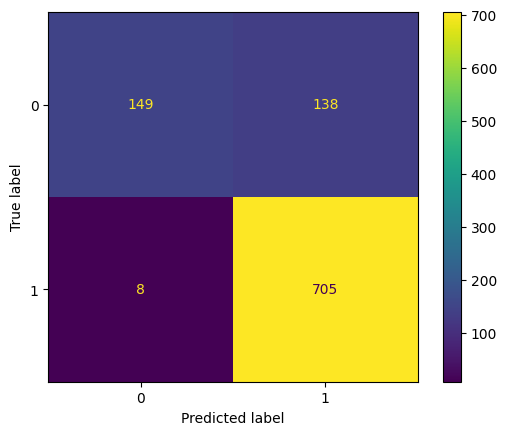

In [394]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Optional: display the matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()